In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv("/mnt/waterchallenge/MainData/00_all_ClimateIndices_and_precip.csv")
df.index = pd.to_datetime(df['date'])

In [ ]:
rainfall = df['precipitation']
rainfall.plot()

In [ ]:
# # Preprocessing
# # Drop all data that doesn't go past 2016
# drop_vars = ["atltri", "brazilrain", "censo_long", "eofpac", "indiamon", "ipotpi_hadisst2", "noi", "swmonsoon", "trend", "epo"]
# for var in drop_vars:
#     df = df.drop(var, axis=1)

In [120]:
df_prefiltered = df[df['date'] >= '1979-01-01']
df_prefiltered = df_prefiltered[df_prefiltered['date'] < '2015-01-01']
df_prefiltered = df_prefiltered.drop('date', axis=1)

In [123]:
df_filtered = df_prefiltered[['precipitation', 'NTA_ersst','ao', 'hurr', 'nao', 'np', 'pna', 'sahelrain', 'tni']]

In [124]:
# df_filtered = df_filtered.dropna()
df_filtered

,precipitation,NTA_ersst,ao,hurr,nao,np,pna,sahelrain,tni
date,,,,,,,,,
1979-01-01,168.1827,-0.01,-2.233,0.00,-2.12,1006.27,-1.54,16.0,-0.343
1979-02-01,207.2732,0.11,-0.697,0.00,-1.20,1014.25,-2.73,-8.0,-0.309
1979-03-01,106.4210,0.14,-0.814,0.00,0.41,1008.15,0.08,2.0,-0.347
1979-04-01,65.0694,0.12,-1.157,0.00,-2.01,1015.65,-0.15,-30.0,-0.187
1979-05-01,38.8513,0.14,-0.250,0.00,-0.90,1013.37,1.27,100.0,0.067
...,...,...,...,...,...,...,...,...,...
2014-08-01,10.7854,0.21,-0.372,4.25,-2.28,1014.39,1.35,184.0,-0.499
2014-09-01,28.0406,0.34,0.102,4.50,1.72,1012.06,0.78,179.0,-0.813
2014-10-01,46.9196,0.34,-1.134,6.75,-0.87,1011.17,1.14,29.0,-1.238


In [ ]:
# day = 60 * 60 * 24      # seconds in a day
# year = 365.2425 * day   # seconds in a year

# temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / day))
# temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
# temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
# temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
# temp_df.head()

In [ ]:
# temp_df = temp_df.drop('Seconds', axis=1)
# temp_df.head()

In [143]:
# Every 5 months try to predict the next month
# [[[p1, ds1, ... (all features)], [p2, ds2], [p3, ds3], [p4, ds4], [p5, ds5]]] [p6] 
# [[[p2, ds2], [p3, ds3], [p4, ds4], [p5, ds5], [p6, ds6]]] [p7]
# etc...

# X is the 3d tensor (matrix), y is the prediction
def df_to_X_y2(df, window_size=12):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    
    y.append(label)
  return np.array(X), np.array(y)

In [144]:
# Create tensors
X2, y2 = df_to_X_y2(df_filtered)
X2.shape, y2.shape
# X2
X2.shape[0]

420

In [145]:
# Split into training, values, and testing
X_train2, y_train2 = X2[:345], y2[:345]
X_val2, y_val2 = X2[345:388], y2[345:388]
X_test2, y_test2 = X2[388:], y2[388:]

X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((345, 12, 9), (345,), (43, 12, 9), (43,), (32, 12, 9), (32,))

In [146]:
# need to scale all values to relative numbers (so large numbers don't overpower small numbers)

def preprocess(X):
    for i in range(0, 9):
        feature_training_mean = np.mean(X_train2[:, :, i])
        feature_training_std = np.std(X_train2[:, :, i])
        X[:, :, i] = (X[:, :, i] - feature_training_mean) / feature_training_std
    return X

In [147]:
preprocess(X_train2)
preprocess(X_val2)
preprocess(X_test2)
X_train2, X_val2, X_test2

(array([[[ 0.98066753,  0.05463353, -2.32131994, ..., -1.51157242,
           0.15624437,  0.21239861],
         [ 1.40619136,  0.42598309, -0.7316514 , ..., -2.68570505,
          -0.04479734,  0.23377439],
         [ 0.30835392,  0.51882048, -0.85273944, ...,  0.08682661,
           0.03897004,  0.20988382],
         ...,
         [ 0.45808218, -0.5333366 , -1.29672889, ...,  1.83322556,
           0.25676523,  0.43244336],
         [ 0.35026133, -0.16198704,  0.48129881, ...,  0.51109303,
           0.28189544,  0.24886317],
         [ 0.91181388,  0.48787468,  1.32994998, ..., -0.6630396 ,
           0.03897004, -0.04851159]],
 
        [[ 1.40619136,  0.42598309, -0.7316514 , ..., -2.68570505,
          -0.04479734,  0.23377439],
         [ 0.30835392,  0.51882048, -0.85273944, ...,  0.08682661,
           0.03897004,  0.20988382],
         [-0.14178336,  0.45692888, -1.20772401, ..., -0.14010658,
          -0.22908557,  0.3104757 ],
         ...,
         [ 0.35026133, -0.1619870

In [148]:
# Multivariate LSTM

model4 = Sequential()
model4.add(InputLayer((12, 9)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                18944     
                                                                 
 dense_16 (Dense)            (None, 8)                 520       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 19,473
Trainable params: 19,473
Non-trainable params: 0
_________________________________________________________________


In [157]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.7), metrics=[RootMeanSquaredError()])

In [160]:
# Fit the model (only save model if validation loss is small)
model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=20, callbacks=[cp4])

Epoch 1/20
 9/11 [=======================>......] - ETA: 0s - loss: 8986.6016 - root_mean_squared_error: 94.7977   

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


11/11 [==============================] - 6s 409ms/step - loss: 8601.7197 - root_mean_squared_error: 92.7455 - val_loss: 7483.3247 - val_root_mean_squared_error: 86.5062
Epoch 2/20
11/11 [==============================] - 0s 10ms/step - loss: 8608.8545 - root_mean_squared_error: 92.7839 - val_loss: 8412.6846 - val_root_mean_squared_error: 91.7207
Epoch 3/20
11/11 [==============================] - 0s 9ms/step - loss: 7836.9897 - root_mean_squared_error: 88.5268 - val_loss: 8790.0000 - val_root_mean_squared_error: 93.7550
Epoch 4/20
11/11 [==============================] - 0s 11ms/step - loss: 8235.4668 - root_mean_squared_error: 90.7495 - val_loss: 8475.2227 - val_root_mean_squared_error: 92.0610
Epoch 5/20
11/11 [==============================] - 0s 9ms/step - loss: 7774.9897 - root_mean_squared_error: 88.1759 - val_loss: 8126.4316 - val_root_mean_squared_error: 90.1467
Epoch 6/20
11/11 [==============================] - 0s 10ms/step - loss: 8190.6426 - root_mean_squared_error: 90.5022

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


11/11 [==============================] - 5s 496ms/step - loss: 7986.9570 - root_mean_squared_error: 89.3698 - val_loss: 7265.9624 - val_root_mean_squared_error: 85.2406
Epoch 10/20
 9/11 [=======================>......] - ETA: 0s - loss: 8418.5908 - root_mean_squared_error: 91.7529

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


11/11 [==============================] - 4s 374ms/step - loss: 7734.3682 - root_mean_squared_error: 87.9453 - val_loss: 6220.3882 - val_root_mean_squared_error: 78.8694
Epoch 11/20
10/11 [==========================>...] - ETA: 0s - loss: 7496.0845 - root_mean_squared_error: 86.5799

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


11/11 [==============================] - 4s 376ms/step - loss: 8151.6284 - root_mean_squared_error: 90.2864 - val_loss: 5573.0845 - val_root_mean_squared_error: 74.6531
Epoch 12/20
10/11 [==========================>...] - ETA: 0s - loss: 8357.6572 - root_mean_squared_error: 91.4202

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


11/11 [==============================] - 4s 433ms/step - loss: 8081.6558 - root_mean_squared_error: 89.8980 - val_loss: 5055.2651 - val_root_mean_squared_error: 71.1004
Epoch 13/20
11/11 [==============================] - 0s 11ms/step - loss: 7994.3833 - root_mean_squared_error: 89.4113 - val_loss: 5288.3809 - val_root_mean_squared_error: 72.7213
Epoch 14/20
11/11 [==============================] - 0s 9ms/step - loss: 7041.1216 - root_mean_squared_error: 83.9114 - val_loss: 5756.3247 - val_root_mean_squared_error: 75.8704
Epoch 15/20
11/11 [==============================] - 0s 11ms/step - loss: 7473.3921 - root_mean_squared_error: 86.4488 - val_loss: 5859.5151 - val_root_mean_squared_error: 76.5475
Epoch 16/20
11/11 [==============================] - 0s 9ms/step - loss: 8037.1919 - root_mean_squared_error: 89.6504 - val_loss: 6724.1670 - val_root_mean_squared_error: 82.0010
Epoch 17/20
11/11 [==============================] - 0s 9ms/step - loss: 7843.4224 - root_mean_squared_error: 88.

In [45]:
def postprocess_precipitation(arr):
  # arr = (arr*precip_training_std) + precip_training_mean
  return arr

In [158]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

# Quickly plot and show prediction vs actual data
def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(postprocess_precipitation(df['Predictions'][start:end]))
    plt.plot(df['Actuals'][start:end])
    plt.show()
    return df, mse(y, predictions)

1/1 [==============================] - 0s 20ms/step


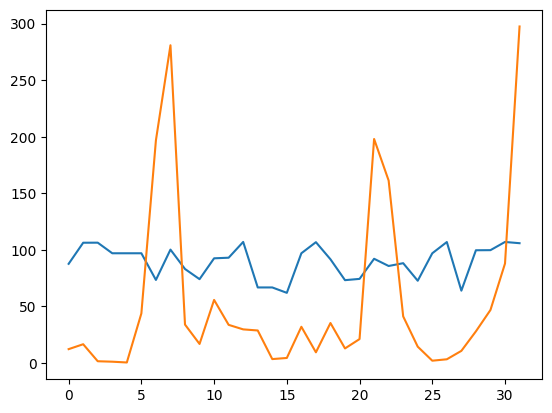

(    Predictions   Actuals
 0     87.706902   12.3038
 1    106.346466   16.6452
 2    106.398613    1.6076
 3     97.037125    1.2084
 4     97.038086    0.5175
 5     97.038208   43.8587
 6     73.467133  196.8465
 7    100.276291  280.8822
 8     83.132751   34.0143
 9     74.145737   16.8840
 10    92.579559   55.8045
 11    93.109665   33.7725
 12   107.050797   29.7707
 13    66.829369   28.7977
 14    66.829498    3.5158
 15    62.067284    4.5060
 16    97.038231   32.0714
 17   106.840645    9.5008
 18    91.716629   35.3942
 19    73.264114   12.9292
 20    74.398956   21.1996
 21    92.164062  198.0503
 22    85.796585  161.3026
 23    88.266273   41.2507
 24    72.761688   14.4935
 25    97.030045    2.0898
 26   106.965057    3.3410
 27    63.997948   10.7854
 28    99.702049   28.0406
 29    99.787811   46.9196
 30   107.028152   87.9625
 31   105.934418  297.4748,
 7269.02481175331)

In [161]:
plot_predictions1(model4, X_test2, y_test2)